## Thu thập dữ liệu gồm OHLC data và corporate action data
- Quá khứ đến 1.10.2025
- Tất cả nếu lấy sau ngày 1.10 thì tuyệt đối không đụng đến để đoạn từ 1.10 đến
31.12 sẽ bung ra sau (giả thực tế)
## Xử lý dữ liệu
- Stock Split
- Dividends
- Missing values & outliers
## Technical Indicators and Build Signal
- Stock Return (Log Returns)
- Build Momentum Signal (tín hiệu có thể là vị trí của giá so với Simple Moving Average (SMA)
hoặc Bollinger Bands)
## Cross-sectional
- Ranking
- Long/Short Position (Mua/Bán n cổ phiếu có thứ hạng cao đến thấp/thấp đến cao, Equal Weighting)
- Rebalancing (Giữ danh mục đầu tư này trong 1 tháng. Vào cuối tháng, đóng tất cả các vị thế, tính toán lại signal,
ranking lại, và mở các vị thế long/short mới cho tháng tiếp theo.)
## Backtesting
- Tính lợi nhuận hàng tháng của danh mục. Lợi nhuận của danh mục là trung bình của lợi nhuận từ các vị thế long và short.
- Statistical Analysis (Hypothesis Testing, "Alpha" - lợi nhuận vượt trội so với thị trường chuẩn, sử dụng QQ Plot để kiểm tra xem nó có "đuôi béo" (fat tails) hay không - cho thấy rủi ro cao hơn so với phân phối chuẩn.)
- Regression (tránh Bias)

### Lưu ý
- Lúc làm data lấy từ 1.2015 đến 31.9.2025
- Pick random 80:20/ 70:30
- 6 tháng / 3 tháng
- 6.2016 - 12.2016, 1.2018-6.2018, 3.2021-12.2021


In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

C:\Users\Tam Nguyen\AppData\Local\Temp\ipykernel_7532\3019252609.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_raw = yf.download(all_tickers, start=start_date, end=end_date)
[**********************62%*****                  ]  8 of 13 completed

Bắt đầu thực hiện chiến lược Momentum Bền Vững (HÀNG NGÀY, 6/2016 - 12/2016)...
Giai đoạn 1: Đang tải và xử lý dữ liệu...


[*********************100%***********************]  13 of 13 completed


Tải dữ liệu thành công. Sử dụng cột 'Close' (đã điều chỉnh).
Đang xử lý missing values (ffill)...
Chiến lược bắt đầu từ (dữ liệu đầu tiên): 2016-06-01
Chiến lược kết thúc vào (dữ liệu cuối cùng): 2016-12-30
Hoàn tất! Đang tạo biểu đồ...


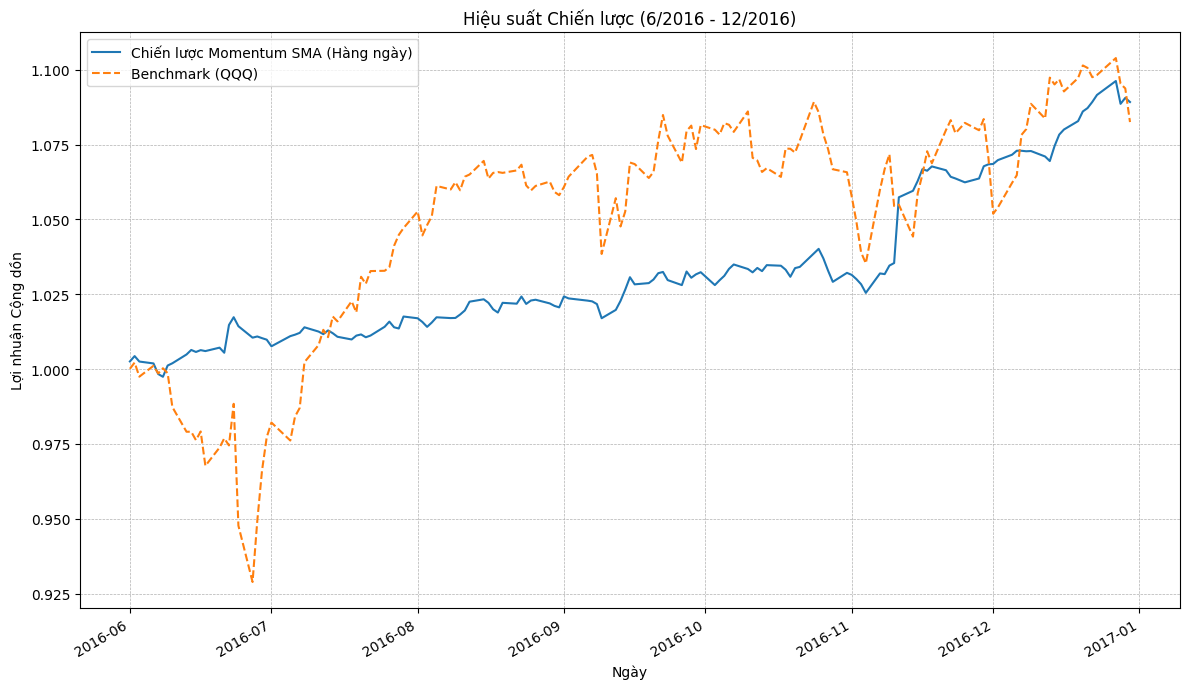

Chương trình kết thúc.


In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

print("Bắt đầu thực hiện chiến lược Momentum Bền Vững (HÀNG NGÀY, 6/2016 - 12/2016)...")

# GIAI ĐOẠN 1: THU THẬP VÀ XỬ LÝ DỮ LIỆU
# -------------------------------------------------
print("Giai đoạn 1: Đang tải và xử lý dữ liệu...")

tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'JPM', 'JNJ', 'XOM', 'PG', 'NVDA', 'V', 'TSLA', 'WMT']
benchmark = 'QQQ'
all_tickers = tickers + [benchmark]

# --- THAY ĐỔI THEO YÊU CẦU ---
# Cần tải dữ liệu từ trước T6/2016 để tính SMA 50 ngày
# (Ví dụ: tải từ T12/2015 để có đủ dữ liệu giả thực tế)
start_date = '2015-12-01'
end_date = '2016-12-31'
# -----------------------------

data = None
data_raw = None

try:
    data_raw = yf.download(all_tickers, start=start_date, end=end_date)

    if data_raw is None or data_raw.empty:
        print("Lỗi: Không tải được dữ liệu.")
    else:
        data = data_raw['Close']
        print("Tải dữ liệu thành công. Sử dụng cột 'Close' (đã điều chỉnh).")

except Exception as e:
    print(f"Lỗi nghiêm trọng xảy ra trong quá trình tải dữ liệu: {e}")

# --- Điểm kiểm tra an toàn ---
if data is None:
    print("Không thể tiếp tục vì dữ liệu không hợp lệ. Dừng chương trình.")
else:
    # GIAI ĐOẠN 1 (Tiếp): XỬ LÝ DỮ LIỆU
    print("Đang xử lý missing values (ffill)...")
    daily_prices = data.ffill()

    # GIAI ĐOẠN 2: KỸ THUẬT ĐẶC TRƯNG (TÍN HIỆU HÀNG NGÀY)
    # -------------------------------------------------

    sma_20 = daily_prices.rolling(window=20).mean()
    sma_50 = daily_prices.rolling(window=50).mean()
    signal_daily = sma_20 / sma_50
    signal_for_trading = signal_daily.shift(1)

    # GIAI ĐOẠN 3: XÂY DỰNG DANH MỤC (HÀNG NGÀY)
    # -------------------------------------------------

    daily_log_returns = np.log(daily_prices / daily_prices.shift(1))
    returns_universe = daily_log_returns[tickers]
    returns_benchmark = daily_log_returns[benchmark]

    top_quintile = 0.8
    bottom_quintile = 0.2
    ranks = signal_for_trading.rank(axis=1, ascending=True, pct=True)
    positions_long = pd.DataFrame(np.where(ranks > top_quintile, 1, 0), index=ranks.index, columns=ranks.columns)
    positions_short = pd.DataFrame(np.where(ranks < bottom_quintile, -1, 0), index=ranks.index, columns=ranks.columns)

    # GIAI ĐOẠN 4: KIỂM THỬ LỊCH SỬ (BACKTESTING)
    # -------------------------------------------------

    long_returns = (positions_long * returns_universe).mean(axis=1)
    short_returns = (positions_short * returns_universe).mean(axis=1)
    strategy_log_returns = long_returns + short_returns

    # -- XỬ LÝ KẾT QUẢ VÀ VẼ BIỂU ĐỒ --
    combined_returns = pd.DataFrame({
        'Strategy': strategy_log_returns,
        'Benchmark': returns_benchmark
    })
    combined_returns = combined_returns.dropna()

    if combined_returns.empty:
        print("Lỗi: Không có dữ liệu lợi nhuận nào sau khi làm sạch.")
    else:
        # --- LỌC KẾT QUẢ THEO ĐÚNG YÊU CẦU ---
        # Chỉ giữ lại dữ liệu trong khoảng thời gian bạn muốn xem
        combined_returns = combined_returns.loc['2016-06-01':'2016-12-31']

        if combined_returns.empty:
             print("Lỗi: Không có dữ liệu trong khoảng 6/2016 - 12/2016 sau khi lọc.")
        else:
            print(f"Chiến lược bắt đầu từ (dữ liệu đầu tiên): {combined_returns.index[0].strftime('%Y-%m-%d')}")
            print(f"Chiến lược kết thúc vào (dữ liệu cuối cùng): {combined_returns.index[-1].strftime('%Y-%m-%d')}")

            # Tính lợi nhuận cộng dồn BẮT ĐẦU TỪ T6/2016
            cumulative_strategy_returns = np.exp(combined_returns['Strategy'].cumsum())
            cumulative_benchmark_returns = np.exp(combined_returns['Benchmark'].cumsum())

            print("Hoàn tất! Đang tạo biểu đồ...")

            plt.figure(figsize=(12, 7))
            cumulative_strategy_returns.plot(label='Chiến lược Momentum SMA (Hàng ngày)')
            cumulative_benchmark_returns.plot(label=f'Benchmark ({benchmark})', linestyle='--')

            # --- CẬP NHẬT TIÊU ĐỀ ---
            plt.title('Hiệu suất Chiến lược (6/2016 - 12/2016)')
            # -------------------------

            plt.ylabel('Lợi nhuận Cộng dồn') # Bỏ thang log vì thời gian ngắn
            plt.xlabel('Ngày')
            plt.legend()
            plt.tight_layout()
            plt.grid(True, which="both", ls="--", linewidth=0.5)

            output_image_path = "momentum_strategy_backtest_2016_6mo.png"
            plt.savefig(output_image_path)

            plt.show()

            print("Chương trình kết thúc.")

# NHẬN XÉT: Hiệu suất Chiến lược (6/2016 - 12/2016)
- Nếu đường Chiến lược cao hơn đường Benchmark điều đó có nghĩa là chiến lượcC đã tạo ra Alpha dương.
- Nếu đường Chiến lược thấp hơn đường Benchmark đã tạo ra Alpha âm. Chiến lược thất bại, ngay cả khi nó vẫn tạo ra lợi nhuận.
Trong biểu đồ ta thấy:
+ Trong suốt 7 tháng được kiểm tra, chiến lược (cam) luôn hoạt động kém hơn (underperform) so với benchmark (xanh).
+ Vậy trong thời gian ngắn chiến lược trên không hiệu quả
